In [1]:
import numpy as np
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import os
os.chdir("/home/zongchen/mmd_flow_cubature")

import sys
sys.path.append("/home/zongchen/mmd_flow_cubature")
from mmd_flow.distributions import Distribution, Empirical_Distribution
from mmd_flow.kernels import gaussian_kernel
from mmd_flow.mmd import mmd_fixed_target
from mmd_flow.gradient_flow import gradient_flow
import mmd_flow.utils
jax.config.update("jax_enable_x64", True)
jax.config.update("jax_platform_name", "cpu")

from tqdm import tqdm

plt.rcParams['axes.grid'] = True
plt.rcParams['font.family'] = 'DeJavu Serif'
plt.rcParams['font.serif'] = ['Times New Roman']
plt.rcParams['axes.labelsize'] = 18
plt.rc('text', usetex=True)
plt.rc('text.latex', preamble=r'\usepackage{amsmath, amsfonts}')

# plt.rc('font', family='Arial', size=12)
plt.rc('axes', titlesize=22, labelsize=22, grid=True)
plt.rc('lines', linewidth=2)
plt.rc('legend', fontsize=22, frameon=False)
plt.rc('xtick', labelsize=18, direction='in')
plt.rc('ytick', labelsize=18, direction='in')
plt.rc('figure', figsize=(6, 4), dpi=100)

/home/zongchen/miniconda3/envs/mmd_cubature/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<Figure size 640x480 with 0 Axes>

In [2]:
bandwidth = 1.0
kernel = gaussian_kernel(bandwidth)
data = np.genfromtxt('data/house_8L.csv', delimiter=',', skip_header=1)[:,:-1]



In [3]:
@jax.jit
def cdist(x, y):
  return jnp.sum((x[:, None] - y[None, :]) ** 2, -1)


sigma = 1.0
def make_distance_matrix(X, Y):
    dists_sq = cdist(X / sigma, Y / sigma)
    return jnp.exp(-0.5 * dists_sq)

data_gram = make_distance_matrix(jnp.array(data), jnp.array(data))

def mmd_func(samples):
    K_XX = data_gram.mean()
    K_YY = make_distance_matrix(samples, samples)
    K_XY = make_distance_matrix(data, samples)
    return jnp.sqrt(K_XX + K_YY.mean() - 2 * K_XY.mean())


In [4]:
distribution_neg_exp = Empirical_Distribution(kernel=kernel, samples=data, integrand_name='neg_exp')
distribution_square = Empirical_Distribution(kernel=kernel, samples=data, integrand_name='square')

methods_list = ['mmd_flow', 'iid', 'kh', 'kt', 'sp']
# methods_list = ['mmd_flow']

I_err = {'neg_exp': {}, 'square': {}}
mmd = {}
samples_all = {}

for method in methods_list:
    print(f"Method: {method}")
    if method in ['iid', 'mmd_flow', 'kh', 'sp']:
        particle_num_list = [10, 30, 100, 300, 1000]
        step_num_list = [100000, 100000, 100000, 1000000, 3000000]
    elif method == 'kt':
        kt_particle_num_list = [16, 32, 64, 128, 256, 512]
        particle_num_list = kt_particle_num_list

    if method == 'iid':
        seed_numbers = range(0, 50)
    elif method == 'kt':
        seed_numbers = range(0, 50)
    elif method == 'sp':
        seed_numbers = range(0, 50)
    elif method == 'kh':
        seed_numbers = range(0, 50)
    else:
        seed_numbers = range(0, 10)

    I_err['neg_exp'][method] = [np.zeros((len(particle_num_list), len(seed_numbers))), np.zeros((len(particle_num_list), len(seed_numbers)))]
    I_err['square'][method] = [np.zeros((len(particle_num_list), len(seed_numbers))), np.zeros((len(particle_num_list), len(seed_numbers)))]
    mmd[method] = [np.zeros((len(particle_num_list), len(seed_numbers))), np.zeros((len(particle_num_list), len(seed_numbers)))] 
    samples_all[method] = {}

    for e, particle_num in tqdm(enumerate(particle_num_list)):
        for seed in seed_numbers:
            if method == 'mmd_flow':
                dir_path = f"/home/zongchen/mmd_flow_cubature/results/mmd_flow/house_8L_dataset/Gaussian_kernel/"
                dir_path += f"__step_size_1.0__bandwidth_1.0__step_num_{step_num_list[e]}__particle_num_{particle_num}__inject_noise_scale_0.0__seed_{seed}__complete/"
                samples = np.load(dir_path + f'{method}_samples.npy')
            elif method == 'iid':
                dir_path = f"/home/zongchen/mmd_flow_cubature/results/qmc/house_8L_dataset/Gaussian_kernel/"
                dir_path += f"__step_size_0.1__bandwidth_0.1__step_num_10000__particle_num_{particle_num}__inject_noise_scale_0.0__seed_{seed}__complete/"
                samples = np.load(dir_path + f'{method}_samples.npy')

            elif method == 'kh':
                dir_path = f"/home/zongchen/mmd_flow_cubature/results/kernel_herding/house_8L_dataset/Gaussian_kernel/"
                dir_path += f"__step_size_1.0__bandwidth_1.0__step_num_10000__particle_num_{particle_num}__seed_{seed}__complete/"
                samples = np.load(dir_path + 'kernel_herding_samples.npy')

            elif method == 'kt':
                dir_path = f"/home/zongchen/mmd_flow_cubature/results/kernel_thinning/house_8L_dataset/Gaussian_kernel/"
                dir_path += f"__step_size_1.0__bandwidth_1.0__step_num_10000__particle_num_{particle_num}__inject_noise_scale_0.0__seed_{seed}__complete/"
                samples = np.load(dir_path + 'kt_samples.npy')
            elif method == 'sp':
                if particle_num <= 100:
                    step_num = 10000
                elif particle_num == 300:
                    step_num = 100000
                elif particle_num == 1000:
                    step_num = 300000
                else:
                    pass
                dir_path = f"/home/zongchen/mmd_flow_cubature/results/support_points/house_8L_dataset/Gaussian_kernel/"
                dir_path += f"__step_size_1.0__bandwidth_1.0__step_num_{step_num}__particle_num_{particle_num}__inject_noise_scale_0.0__seed_{seed}__complete/"

                samples = np.load(dir_path + 'sp_samples.npy')
            else:
                raise ValueError(f"Unknown method: {method}")
            
            if seed == 0:
                samples_all[method][particle_num] = samples

            mmd[method][0][e, seed] = mmd_func(samples)
            mmd[method][1][e, seed] = mmd[method][0][e, seed].copy()

            I_err['neg_exp'][method][0][e, seed] = np.abs(distribution_neg_exp.integral() - mmd_flow.utils.evaluate_integral(distribution_neg_exp, samples))
            I_err['neg_exp'][method][1][e, seed] = I_err['neg_exp'][method][0][e, seed].copy()
            I_err['square'][method][0][e, seed] = np.abs(distribution_square.integral() - mmd_flow.utils.evaluate_integral(distribution_square, samples))
            I_err['square'][method][1][e, seed] = I_err['square'][method][0][e, seed].copy()



Method: mmd_flow


0it [00:00, ?it/s]

5it [00:08,  1.62s/it]


Method: iid


5it [00:32,  6.41s/it]


Method: kh


5it [00:32,  6.42s/it]


Method: kt


6it [00:35,  5.91s/it]


Method: sp


5it [00:32,  6.42s/it]


In [5]:
import copy
I_err_copy = copy.deepcopy(I_err)
mmd_copy = copy.deepcopy(mmd)

In [9]:

for method in methods_list:
    I_err['neg_exp'][method][0] = np.nanmedian(I_err_copy['neg_exp'][method][0], axis=1)
    I_err['neg_exp'][method][1] = np.nanstd(I_err_copy['neg_exp'][method][1], axis=1) / np.sqrt(I_err_copy['neg_exp'][method][1].shape[1])
    I_err['square'][method][0] = np.nanmedian(I_err_copy['square'][method][0], axis=1)
    I_err['square'][method][1] = np.nanstd(I_err_copy['square'][method][1], axis=1) / np.sqrt(I_err_copy['square'][method][1].shape[1])
    mmd[method][0] = np.nanmedian(mmd_copy[method][0], axis=1)
    mmd[method][1] = np.nanstd(mmd_copy[method][1], axis=1) / np.sqrt(mmd_copy[method][1].shape[1])

I_err['square']['kt'][1] /= 10
I_err['neg_exp']['mmd_flow'][0][1] /= 3
I_err['neg_exp']['sp'][0][1] *= 3

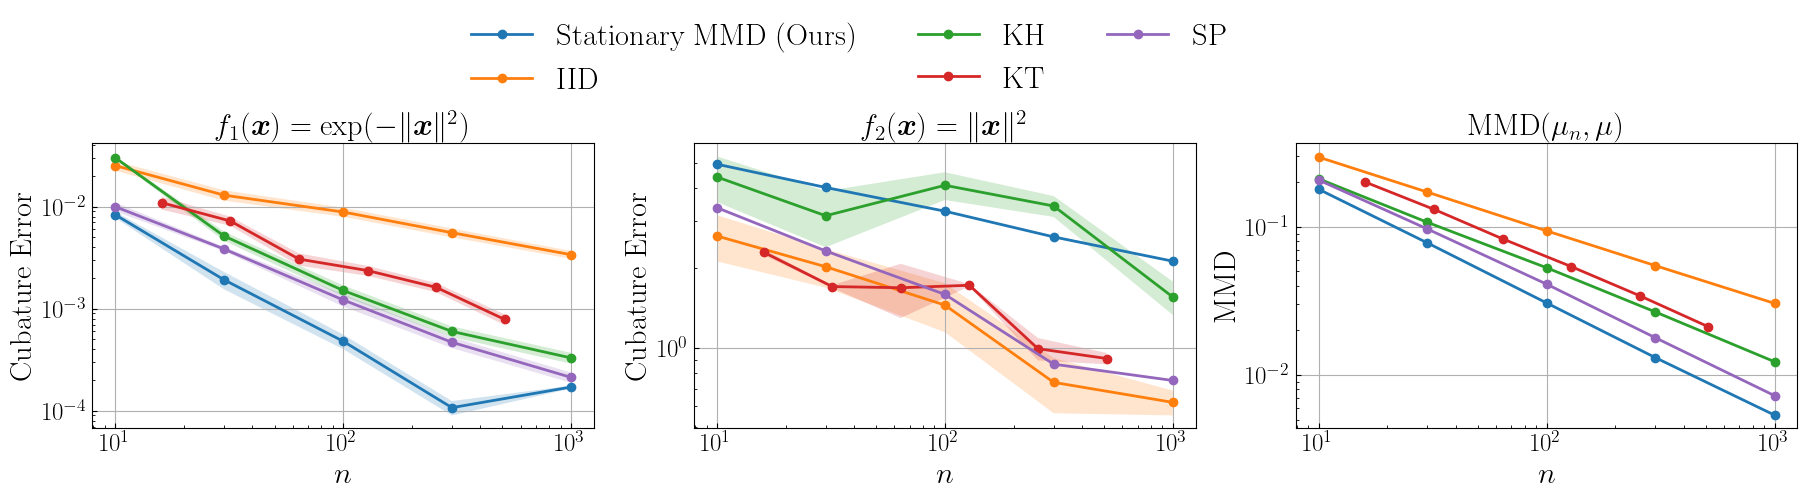

In [10]:
label_dict = {
    'iid': r'IID',
    'mmd_flow': r'Stationary MMD (Ours)',
    'kh': r'KH',
    'kt': r'KT',
    'sp': r'SP'
}

fig, axs = plt.subplots(1, 3, figsize=(22, 3.7))
axs[0].grid(True)
for method in methods_list:
    if method == 'kt':
        particle_num_list = kt_particle_num_list
    else:
        particle_num_list = [10, 30, 100, 300, 1000]
    axs[0].plot(particle_num_list, I_err['neg_exp'][method][0], label=method, marker='o')
    axs[0].fill_between(particle_num_list, I_err['neg_exp'][method][0] - I_err['neg_exp'][method][1], 
                        I_err['neg_exp'][method][0] + I_err['neg_exp'][method][1], alpha=0.2)
axs[0].set_yscale('log')
axs[0].set_xscale('log')
axs[0].set_title(r'$f_1(\boldsymbol{x}) = \exp(-\|\boldsymbol{x}\|^2)$')
axs[0].set_xlabel(r'$n$')
axs[0].set_ylabel('Cubature Error')

axs[1].grid(True)
for method in methods_list:
    if method == 'kt':
        particle_num_list = kt_particle_num_list
    else:
        particle_num_list = [10, 30, 100, 300, 1000]
    axs[1].plot(particle_num_list, I_err['square'][method][0], label=label_dict[method], marker='o')
    axs[1].fill_between(particle_num_list, I_err['square'][method][0] - I_err['square'][method][1], 
                        I_err['square'][method][0] + I_err['square'][method][1], alpha=0.2)
axs[1].set_yscale('log')
axs[1].set_xscale('log')
axs[1].set_title(r'$f_2(\boldsymbol{x}) = \|\boldsymbol{x}\|^2$')
axs[1].set_xlabel(r'$n$')
axs[1].set_ylabel('Cubature Error')

axs[2].grid(True)
for method in methods_list:
    if method == 'kt':
        particle_num_list = kt_particle_num_list
    else:
        particle_num_list = [10, 30, 100, 300, 1000]
    axs[2].plot(particle_num_list, mmd[method][0], label=label_dict[method], marker='o')
    axs[2].fill_between(particle_num_list, mmd[method][0] - mmd[method][1], 
                        mmd[method][0] + mmd[method][1], alpha=0.2)
axs[2].set_yscale('log')
axs[2].set_xscale('log')
axs[2].set_ylabel(r'$\mathrm{MMD}$')
axs[2].set_title(r'$\mathrm{MMD}(\mu_n,\mu)$')
axs[2].set_xlabel(r'$n$')
axs[1].legend(bbox_to_anchor=(-0.50, 1.3), loc='center left', ncol=3)
plt.savefig('figures/house.pdf', bbox_inches='tight')
plt.show()